In [1]:
import os
import warnings
import argparse
import matplotlib
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
from scipy import stats
from pathlib import Path
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix, coo_matrix, csc_matrix
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.serif'] = ['Arial']
warnings.filterwarnings("ignore")

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

def jump_up_one_dir():
    new_dir = Path().resolve().parent
    os.chdir(new_dir)
    print("✅ 当前工作目录跳转至:", new_dir)

jump_up_one_dir()


✅ 当前工作目录跳转至: C:\Users\Jeming\Desktop\T0


In [2]:
# 加载数据/home/musg/code_file/2025/T1-data
# 导入数据
file_fold = './0-dataset/'  
adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_true = adata_omics2.copy()
print("✅ 导入数据:", file_fold)

✅ 导入数据: ./0-dataset/


### note开始：这里应该不用动 

In [3]:
adata_miss = adata_omics2.copy()
# Step 1: 数据划分
x_coords = adata_miss.obsm['spatial'][:, 1]  ## 假设y轴在第0列(纵向)、x轴在第1列(横向)
sorted_indices = np.argsort(x_coords)

# 自定义缺失比例（例如10%）
missing_ratio = 0.5      # 例如50%
split_size = int(adata_miss.shape[0] * missing_ratio)
split2_indices = sorted_indices[:split_size]
split1_indices = sorted_indices[split_size:]  # 第二部分数据

# Step 5: 将RNA数据和蛋白数据分别划分到adata_batch1和adata_batch2
# 按照split1_indices和split2_indices划分batch1和batch2
adata_batch1 = adata_omics1[split1_indices].copy()  # Batch 1 RNA
adata_batch2 = adata_omics1[split2_indices].copy()  # Batch 2 RNA

adata_batch1.X = adata_batch1.X.toarray()
adata_batch2.X = adata_batch2.X.toarray()

# 将蛋白数据也划分到batch1和batch2中
# adata_batch1.obsm['protein_expression'] = adata_omics2.X[split1_indices].toarray()
# adata_batch2.obsm['protein_expression'] = adata_omics2.X[split2_indices].toarray()

print("✅ 数据划分完成")

✅ 数据划分完成


In [4]:
adata_batch1.obsm['protein_expression'] = adata_omics2.X[split1_indices]
adata_batch1.obsm['protein_expression'].columns = adata_omics2.var.index
adata_batch1.obsm['protein_expression'].index = adata_batch1.obs_names

adata_batch2.obsm['protein_expression'] = adata_omics2.X[split2_indices]
adata_batch2.obsm['protein_expression'].columns = adata_omics2.var.index
adata_batch2.obsm['protein_expression'].index = adata_batch2.obs_names
###缺失部分的真实值
adata_batch2
print("✅ 数据划分完成")

✅ 数据划分完成


In [5]:
test_data = adata_batch2.copy()
test_data.obsm['protein_expression'].columns= adata_omics2.var.index
test_data.obsm['protein_expression'].index = adata_batch2.obs_names

true_data = test_data.obsm['protein_expression']
true_data.columns = adata_omics2.var.index
true_data.index = adata_batch2.obs_names
true_data.columns = true_data.columns.str.replace("-","_")
true_data.columns = true_data.columns.str.replace(".","_")
print("✅ 数据划分完成")

✅ 数据划分完成


In [6]:
true_data

<1742x31 sparse matrix of type '<class 'numpy.float32'>'
	with 53146 stored elements in Compressed Sparse Row format>

In [7]:
train_data = adata_batch1.copy()
train_data.obsm['protein_expression'].columns = adata_omics2.var.index
train_data.obsm['protein_expression'].index = adata_batch1.obs_names

train_data.obsm['protein_expression'].columns = train_data.obsm['protein_expression'].columns.str.replace("-","_")
train_data.obsm['protein_expression'].columns = train_data.obsm['protein_expression'].columns.str.replace(".","_")
print("✅ 数据划分完成")

✅ 数据划分完成


### 1-cTPnet

In [8]:
cTPnet_pre = pd.read_csv('./3-each adt/S1-1-1-cTPnet.csv', index_col=0)
adata1 = sc.AnnData(cTPnet_pre)
print("✅ S1-1-1 csv import success")

✅ S1-1-1 csv import success


### 2-scArches

In [9]:
## 读入
scArches_pre = pd.read_csv('./3-each adt/S1-1-2-scArches.csv', index_col=0)
adata2 = sc.AnnData(scArches_pre)
print("✅ S1-1-2 csv import success")


✅ S1-1-2 csv import success


### 3-sciPENN 

In [10]:
## 读入
sciPENN_pre = pd.read_csv('./3-each adt/S1-1-3-reversed_sciPENN_pre.csv', index_col=0)
adata3 = sc.AnnData(sciPENN_pre)
print("✅ S1-1-3 csv import success")


✅ S1-1-3 csv import success


### 4-spamosaic 

In [11]:
## 读入
spamosaic_pre = pd.read_csv('./3-each adt/S1-1-4-spamosaic.csv', index_col=0)
adata4 = sc.AnnData(spamosaic_pre)
print("✅ S1-1-4 csv import success")


✅ S1-1-4 csv import success


### 5-Ours

In [12]:
## 读入
ourbaseline_pre = pd.read_csv('./3-each adt/S1-1-5-T1-reversed_our-new.csv', index_col=0)
adata5 = sc.AnnData(ourbaseline_pre)
print("✅ S1-1-5 csv import success")


✅ S1-1-5 csv import success


In [13]:
adata_true

AnnData object with n_obs × n_vars = 3484 × 31
    obs: 'lab', 'lab_lynn', 'src', 'final_annot'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [14]:
cTPnet_pre.columns = cTPnet_pre.columns.str.replace("-","_")
cTPnet_pre.columns = cTPnet_pre.columns.str.replace(".","_")
scArches_pre.columns = scArches_pre.columns.str.replace("-","_")
# Dengkw_pre.columns = Dengkw_pre.columns.str.replace("-","_")
# cTp_net_pre.columns = cTp_net_pre.columns.str.replace("-","_")
# Seurat_pre.columns = Seurat_pre.columns.str.replace("-","_")
# Seurat_pre.columns = Seurat_pre.columns.str.replace(".","_")
# Liger_pre.columns = Liger_pre.columns.str.replace("-","_")
# Liger_pre.columns = Liger_pre.columns.str.replace(".","_")
sciPENN_pre.columns = sciPENN_pre.columns.str.replace("-","_")
sciPENN_pre.columns = sciPENN_pre.columns.str.replace(".","_")
# scVAEIT_pre.columns = scVAEIT_pre.columns.str.replace("-","_")
# scVAEIT_pre.columns = scVAEIT_pre.columns.str.replace(".","_")

spamosaic_pre.columns = spamosaic_pre.columns.str.replace("-","_")
spamosaic_pre.columns = spamosaic_pre.columns.str.replace(".","_")

ourbaseline_pre.columns = ourbaseline_pre.columns.str.replace("-","_")
ourbaseline_pre.columns = ourbaseline_pre.columns.str.replace(".","_")
print("✅ 数据列名替换完成")

✅ 数据列名替换完成


In [15]:
proteins_inter = train_data.obsm['protein_expression'].columns.intersection(true_data.columns)
proteins_inter

Index(['CD163', 'CR2', 'PCNA', 'VIM', 'KRT5', 'CD68', 'CEACAM8', 'PTPRC',
       'HLA_DRA', 'PAX5', 'SDC1', 'PTPRC_1', 'CD8A', 'BCL2', 'CD19', 'PDCD1',
       'ACTA2', 'FCGR3A', 'ITGAX', 'CXCR5', 'EPCAM', 'MS4A1', 'CD3E', 'CD14',
       'CD40', 'PECAM1', 'CD4', 'ITGAM', 'CD27', 'CCR7', 'CD274'],
      dtype='object')

In [16]:
# scMoGNN_pre = pd.DataFrame(data = scMoGNN_pre.values, index = true_data.index , columns = proteins_inter)
# CMAE_pre = pd.DataFrame(data = CMAE_pre.values, index = true_data.index , columns = train_data.obsm['protein_expression'].columns)
# CMAE_pre = CMAE_pre[proteins_inter]
# BABEL_pre = pd.DataFrame(data = BABEL_pre.values, index = true_data.index , columns = train_data.obsm['protein_expression'].columns)
# BABEL_pre = BABEL_pre[proteins_inter]
cTPnet_pre = cTPnet_pre[proteins_inter]
scArches_pre = scArches_pre[proteins_inter]
# Dengkw_pre = Dengkw_pre[proteins_inter]
# cTp_net_pre = cTp_net_pre[proteins_inter]
# Seurat_pre = Seurat_pre[proteins_inter]
# Liger_pre = Liger_pre[proteins_inter]
sciPENN_pre = sciPENN_pre[proteins_inter]
spamosaic_pre = spamosaic_pre[proteins_inter]
print("✅ 数据列名替换完成")

✅ 数据列名替换完成


In [17]:
ourbaseline_pre = ourbaseline_pre[proteins_inter]
print("✅ 数据列名替换完成")

✅ 数据列名替换完成


In [18]:
# 假设 proteins_inter 是一个包含蛋白质标识符的列表
# adata_omics2 是一个 AnnData 对象

# 获取 adata_omics2.var.index 的索引
index_map = {protein: idx for idx, protein in enumerate(true_data.columns)}

# 将 proteins_inter 中的字符串转换为整数索引
integer_indices = [index_map[protein] for protein in proteins_inter]

# 使用整数索引访问稀疏矩阵
true_data_subset = true_data[:, integer_indices]

# 将稀疏矩阵转换为 DataFrame
true_data_df = pd.DataFrame(
    true_data_subset.toarray(),  # 将稀疏矩阵转换为密集矩阵
    index=adata_batch2.obs.index,  # 行索引
    columns=proteins_inter  # 列索引
)
true_data = true_data_df.copy()
true_data

,CD163,CR2,PCNA,VIM,KRT5,CD68,CEACAM8,PTPRC,HLA_DRA,PAX5,...,MS4A1,CD3E,CD14,CD40,PECAM1,CD4,ITGAM,CD27,CCR7,CD274
s1-GTCGTGCTAATGCCTT-1,21064.0,34516.0,4935.0,42935.0,774.0,15903.0,4032.0,19483.0,15612.0,2258.0,...,5838.0,90967.0,20870.0,30290.0,16161.0,75870.0,6774.0,34612.0,25451.0,2645.0
s1-GTCACTTACGTGTATG-1,19473.0,31710.0,10921.0,82763.0,1184.0,28026.0,11315.0,22631.0,17105.0,2105.0,...,7105.0,88684.0,26052.0,37500.0,34473.0,65657.0,8684.0,55263.0,23947.0,5394.0
s1-CATGCATATGACGTCG-1,20273.0,34350.0,6332.0,45535.0,683.0,18496.0,1936.0,22460.0,28382.0,1822.0,...,5740.0,178838.0,19453.0,33166.0,13621.0,83940.0,4829.0,50797.0,26765.0,2733.0
s1-TGCGATGCAGGTGCGA-1,31438.0,92610.0,7876.0,37256.0,508.0,15553.0,973.0,18893.0,42721.0,5508.0,...,8783.0,88252.0,23207.0,49668.0,11725.0,75597.0,33340.0,34092.0,27500.0,3384.0
s1-ATTATGATACTGCGCA-1,13571.0,29285.0,10357.0,36785.0,357.0,10000.0,6785.0,7500.0,5714.0,4642.0,...,5000.0,21428.0,14285.0,25714.0,18214.0,29285.0,6428.0,31785.0,12857.0,2142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s1-ACCAAGTGGCTGTATG-1,18953.0,30348.0,5348.0,15697.0,465.0,8372.0,1279.0,6976.0,3139.0,930.0,...,4418.0,58488.0,14767.0,26046.0,8604.0,34767.0,3953.0,27441.0,12674.0,930.0
s1-TCGCGGTAGTATGATC-1,15512.0,42438.0,4558.0,13109.0,212.0,4063.0,1024.0,17279.0,16148.0,3286.0,...,8763.0,59151.0,19681.0,50918.0,7809.0,43922.0,5689.0,38621.0,21625.0,883.0
s1-CTTACGAACTCCGTCC-1,32142.0,43571.0,6571.0,49857.0,285.0,16571.0,428.0,19428.0,3857.0,3428.0,...,6428.0,42714.0,23428.0,60285.0,15000.0,46000.0,5428.0,33428.0,21857.0,3714.0
s1-GAGTTAATTCCACTGG-1,30465.0,38372.0,5813.0,54883.0,697.0,12790.0,465.0,26279.0,4651.0,3720.0,...,6744.0,57441.0,20232.0,45348.0,16744.0,46511.0,5116.0,30000.0,27209.0,1627.0


# compute PCCs #

### 1 totalVI ###

In [19]:
cTPnet_pcc_protein = []
for i in range(cTPnet_pre.shape[1]):
    x = np.array(cTPnet_pre[cTPnet_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    cTPnet_pcc_protein.append(pcc)
cTPnet_pcc_cell = []
for i in range(cTPnet_pre.shape[0]):
    x = np.array((cTPnet_pre.T)[cTPnet_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    cTPnet_pcc_cell.append(pcc)

print("✅ cTPnet_pcc_protein计算完成")

✅ cTPnet_pcc_protein计算完成


### 2 scArches ###

In [20]:
scArches_pcc_protein = []
for i in range(scArches_pre.shape[1]):
    x = np.array(scArches_pre[scArches_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    scArches_pcc_protein.append(pcc)
scArches_pcc_cell = []
for i in range(scArches_pre.shape[0]):
    x = np.array((scArches_pre.T)[scArches_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    scArches_pcc_cell.append(pcc)

print("✅ scArches_pcc_protein计算完成")

✅ scArches_pcc_protein计算完成


### 3 sciPENN

In [21]:
A = ad.AnnData(X = true_data).copy()
B = pd.DataFrame(data = A.X,columns = A.var_names,index = A.obs_names)
C_true_data = (B.T[sciPENN_pre.index]).T
print("✅ C_true_data计算完成")

✅ C_true_data计算完成


In [22]:
C_true_data

,CD163,CR2,PCNA,VIM,KRT5,CD68,CEACAM8,PTPRC,HLA_DRA,PAX5,...,MS4A1,CD3E,CD14,CD40,PECAM1,CD4,ITGAM,CD27,CCR7,CD274
s1-GTCGTGCTAATGCCTT-1,21064.0,34516.0,4935.0,42935.0,774.0,15903.0,4032.0,19483.0,15612.0,2258.0,...,5838.0,90967.0,20870.0,30290.0,16161.0,75870.0,6774.0,34612.0,25451.0,2645.0
s1-GTCACTTACGTGTATG-1,19473.0,31710.0,10921.0,82763.0,1184.0,28026.0,11315.0,22631.0,17105.0,2105.0,...,7105.0,88684.0,26052.0,37500.0,34473.0,65657.0,8684.0,55263.0,23947.0,5394.0
s1-CATGCATATGACGTCG-1,20273.0,34350.0,6332.0,45535.0,683.0,18496.0,1936.0,22460.0,28382.0,1822.0,...,5740.0,178838.0,19453.0,33166.0,13621.0,83940.0,4829.0,50797.0,26765.0,2733.0
s1-TGCGATGCAGGTGCGA-1,31438.0,92610.0,7876.0,37256.0,508.0,15553.0,973.0,18893.0,42721.0,5508.0,...,8783.0,88252.0,23207.0,49668.0,11725.0,75597.0,33340.0,34092.0,27500.0,3384.0
s1-ATTATGATACTGCGCA-1,13571.0,29285.0,10357.0,36785.0,357.0,10000.0,6785.0,7500.0,5714.0,4642.0,...,5000.0,21428.0,14285.0,25714.0,18214.0,29285.0,6428.0,31785.0,12857.0,2142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s1-ACCAAGTGGCTGTATG-1,18953.0,30348.0,5348.0,15697.0,465.0,8372.0,1279.0,6976.0,3139.0,930.0,...,4418.0,58488.0,14767.0,26046.0,8604.0,34767.0,3953.0,27441.0,12674.0,930.0
s1-TCGCGGTAGTATGATC-1,15512.0,42438.0,4558.0,13109.0,212.0,4063.0,1024.0,17279.0,16148.0,3286.0,...,8763.0,59151.0,19681.0,50918.0,7809.0,43922.0,5689.0,38621.0,21625.0,883.0
s1-CTTACGAACTCCGTCC-1,32142.0,43571.0,6571.0,49857.0,285.0,16571.0,428.0,19428.0,3857.0,3428.0,...,6428.0,42714.0,23428.0,60285.0,15000.0,46000.0,5428.0,33428.0,21857.0,3714.0
s1-GAGTTAATTCCACTGG-1,30465.0,38372.0,5813.0,54883.0,697.0,12790.0,465.0,26279.0,4651.0,3720.0,...,6744.0,57441.0,20232.0,45348.0,16744.0,46511.0,5116.0,30000.0,27209.0,1627.0


In [23]:
sciPENN_pcc_protein = []
for i in range(sciPENN_pre.shape[1]):
    x = np.array(sciPENN_pre[sciPENN_pre.columns[i]])
    y = np.array(C_true_data[C_true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    sciPENN_pcc_protein.append(pcc)
sciPENN_pcc_cell = []
for i in range(sciPENN_pre.shape[0]):
    x = np.array((sciPENN_pre.T)[sciPENN_pre.index[i]])
    y = np.array((C_true_data.T)[C_true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    sciPENN_pcc_cell.append(pcc)

print("✅ sciPENN_pcc_protein计算完成")

✅ sciPENN_pcc_protein计算完成


### 4 SpaMosaic

In [24]:
spamosaic_pcc_protein = []
for i in range(spamosaic_pre.shape[1]):
    x = np.array(spamosaic_pre[spamosaic_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    spamosaic_pcc_protein.append(pcc)
spamosaic_pcc_cell = []
for i in range(spamosaic_pre.shape[0]):
    x = np.array((spamosaic_pre.T)[spamosaic_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    spamosaic_pcc_cell.append(pcc)

print("✅ spamosaic_pcc_protein计算完成")

✅ spamosaic_pcc_protein计算完成


### 5 ourbaseline

In [25]:
our_pcc_protein = []
for i in range(ourbaseline_pre.shape[1]):
    x = np.array(ourbaseline_pre[ourbaseline_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    pcc = pearsonr(x,y)[0]
    our_pcc_protein.append(pcc)
our_pcc_cell = []
for i in range(ourbaseline_pre.shape[0]):
    x = np.array((ourbaseline_pre.T)[ourbaseline_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    pcc = pearsonr(x,y)[0]
    our_pcc_cell.append(pcc)

print("✅ ourbaseline_pcc_protein计算完成")

✅ ourbaseline_pcc_protein计算完成


### note结束：到这里这里应该都不用动 

### Summary PCC results

### 图1：也许需要修改

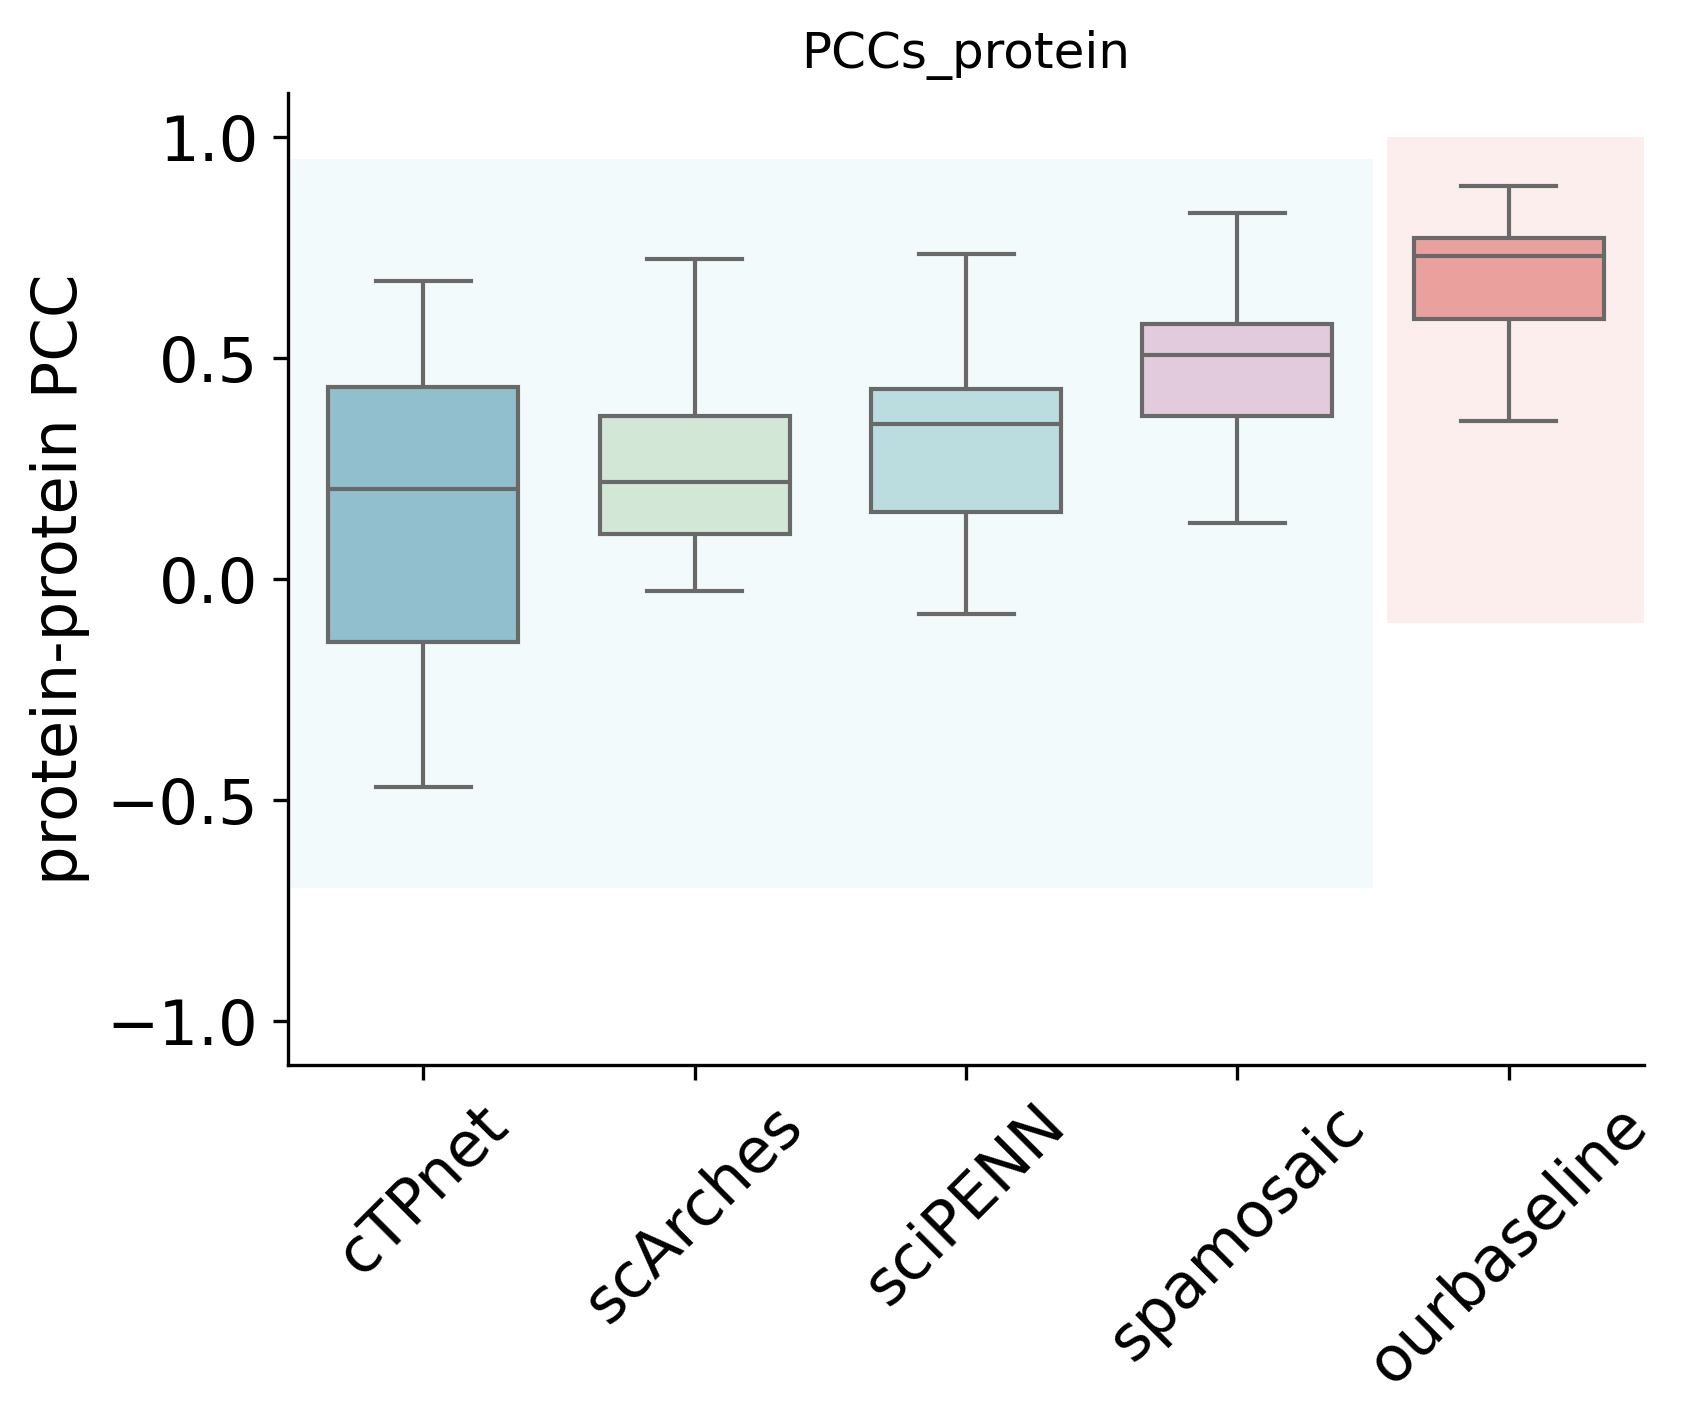

In [26]:
from matplotlib.patches import Rectangle  # 导入 Rectangle 类
### 颜色自定义设置
my_pal = {
    'cTPnet':'#88c4d7',
    'scArches':'#d0ead5',
    'sciPENN':'#b5e2e5',
    'spamosaic':'#e6c7df',
    'ourbaseline':'#f79691'
    }
pro_columns = true_data.columns
cell_columns = true_data.index

index = ['cTPnet','scArches','sciPENN','spamosaic','ourbaseline']
pro_columns = true_data.columns
cell_columns = true_data.index
PCCs_protein = pd.DataFrame([cTPnet_pcc_protein,scArches_pcc_protein,sciPENN_pcc_protein,spamosaic_pcc_protein,our_pcc_protein],index = index,columns = pro_columns)
PCCs_cell = pd.DataFrame([cTPnet_pcc_cell,scArches_pcc_cell,sciPENN_pcc_cell,spamosaic_pcc_cell,our_pcc_cell],index = index,columns = cell_columns)




# 设置字体
font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15}
plt.rc('font', **font)
# 绘制垂直箱线图
plt.figure(figsize=(6, 5), dpi=300)
fig1 = sns.boxplot(data=PCCs_protein.T, orient="v", linewidth=1, width=0.7, palette=my_pal, fliersize=0, flierprops={'marker': 'o'})
# 设置坐标轴标签
fig1.set_ylabel("protein-protein PCC")
fig1.set_xlabel("")
# 设置坐标轴范围
fig1.set_ylim(-1.1, 1.1)
# 去掉顶部和右侧边框
fig1.spines['top'].set_visible(False)
fig1.spines['right'].set_visible(False)
plt.xticks(rotation=45)  # 旋转 x 轴标签，避免重叠
# 设置标题
plt.title("PCCs_protein", fontdict={'size': 12})

# 添加两个颜色的框
# 去掉顶部和右侧边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax = plt.gca()
# 浅蓝色框
ax.add_patch(Rectangle((-0.5, -0.7), 4, 1.65, facecolor='#b5e2e5', alpha=0.15, edgecolor='none', zorder=0))
# 浅灰色框
ax.add_patch(Rectangle((3.55, -0.1), 4, 1.1, facecolor='#EE9185', alpha=0.15, edgecolor='none', zorder=0))

# 显示图形
plt.tight_layout()
plt.show()

### 计算SPCC指标

### totalVI ###

In [27]:
from scipy.stats import spearmanr
cTPnet_spcc_protein = []
for i in range(cTPnet_pre.shape[1]):
    x = np.array(cTPnet_pre[cTPnet_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    cTPnet_spcc_protein.append(spcc)
cTPnet_spcc_cell = []
for i in range(cTPnet_pre.shape[0]):
    x = np.array((cTPnet_pre.T)[cTPnet_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    cTPnet_spcc_cell.append(spcc)

print("✅ totaIVL计算完成")

✅ totaIVL计算完成


### scArches ###

In [28]:
scArches_spcc_protein = []
for i in range(scArches_pre.shape[1]):
    x = np.array(scArches_pre[scArches_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    scArches_spcc_protein.append(spcc)
scArches_spcc_cell = []
for i in range(scArches_pre.shape[0]):
    x = np.array((scArches_pre.T)[scArches_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    scArches_spcc_cell.append(spcc)

print("✅ scArches_spcc_protein计算完成")

✅ scArches_spcc_protein计算完成


### sciPENN

In [29]:
sciPENN_spcc_protein = []
for i in range(sciPENN_pre.shape[1]):
    x = np.array(sciPENN_pre[sciPENN_pre.columns[i]])
    y = np.array(C_true_data[C_true_data.columns[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    sciPENN_spcc_protein.append(spcc)
sciPENN_spcc_cell = []
for i in range(sciPENN_pre.shape[0]):
    x = np.array((sciPENN_pre.T)[sciPENN_pre.index[i]])
    y = np.array((C_true_data.T)[C_true_data.index[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    sciPENN_spcc_cell.append(spcc)

print("✅ sciPENN_spcc_protein计算完成")

✅ sciPENN_spcc_protein计算完成


### SpaMosaic

In [30]:
spamosaic_spcc_protein = []
for i in range(spamosaic_pre.shape[1]):
    x = np.array(spamosaic_pre[spamosaic_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    spamosaic_spcc_protein.append(spcc)
spamosaic_spcc_cell = []
for i in range(spamosaic_pre.shape[0]):
    x = np.array((spamosaic_pre.T)[spamosaic_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])    
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    spamosaic_spcc_cell.append(spcc)

print("✅ spamosaic_spcc_protein计算完成")

✅ spamosaic_spcc_protein计算完成


### Our Baseline

In [31]:
# 计算蛋白质水平的 SPCC
our_spcc_protein = []
for i in range(ourbaseline_pre.shape[1]):
    x = np.array(ourbaseline_pre[ourbaseline_pre.columns[i]])
    y = np.array(true_data[true_data.columns[i]])
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    our_spcc_protein.append(spcc)

# 计算细胞水平的 SPCC
our_spcc_cell = []
for i in range(ourbaseline_pre.shape[0]):
    x = np.array((ourbaseline_pre.T)[ourbaseline_pre.index[i]])
    y = np.array((true_data.T)[true_data.index[i]])
    spcc = spearmanr(x, y)[0]  # 取相关系数，忽略 p 值
    our_spcc_cell.append(spcc)

print("✅ ourbaseline_spcc_protein计算完成")

✅ ourbaseline_spcc_protein计算完成


### 图2：也许需要修改

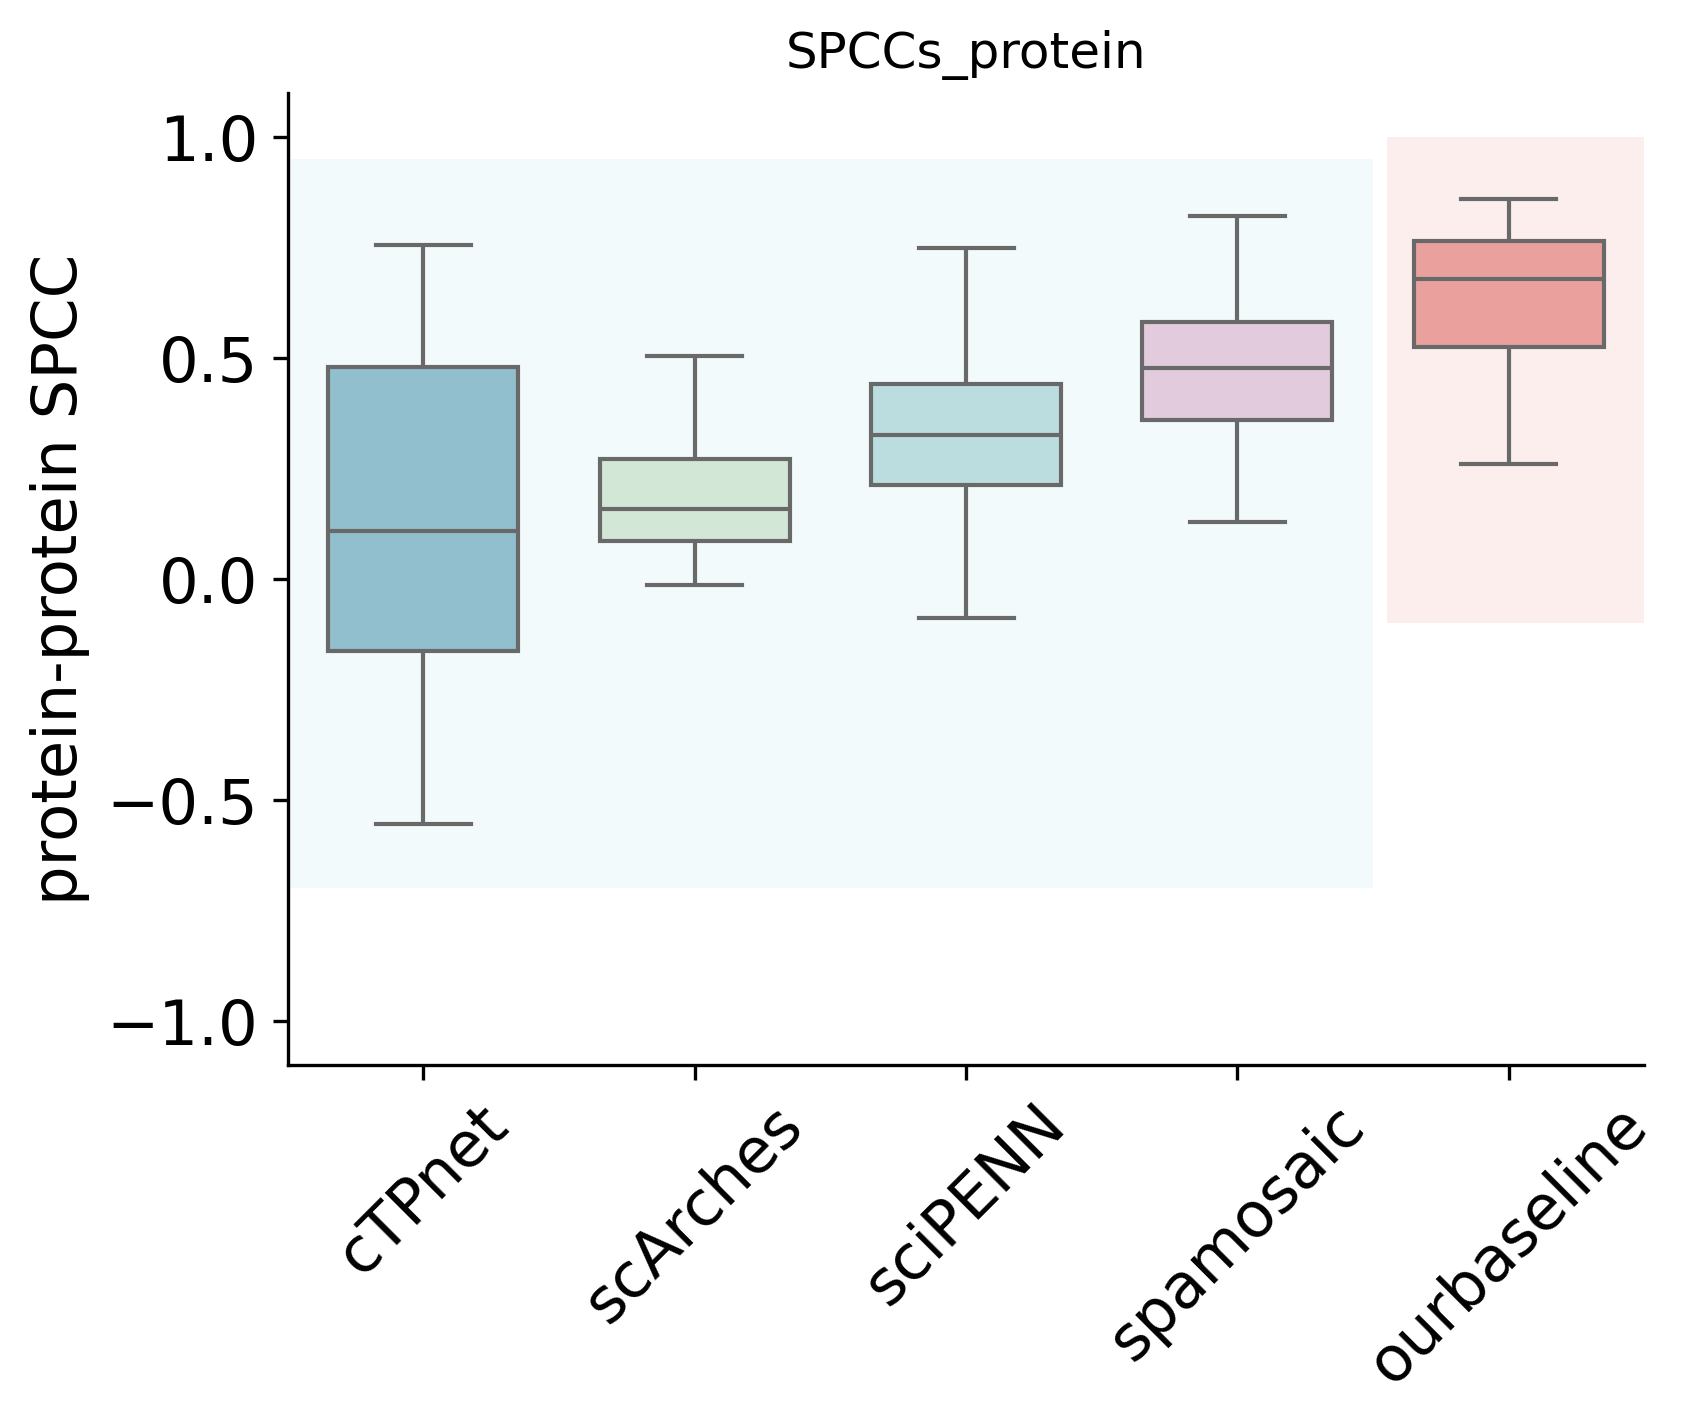

In [32]:
# 颜色自定义
my_pal_spcc = {'cTPnet':'#88c4d7','scArches':'#d0ead5','sciPENN':'#b5e2e5','spamosaic':'#e6c7df','ourbaseline':'#f79691'}
pro_columns_spcc = true_data.columns
cell_columns_spcc = true_data.index

index = ['cTPnet','scArches','sciPENN','spamosaic','ourbaseline']
pro_columns = true_data.columns
cell_columns = true_data.index
SPCCs_protein = pd.DataFrame([cTPnet_spcc_protein,scArches_spcc_protein,sciPENN_spcc_protein,spamosaic_spcc_protein,our_spcc_protein],index = index,columns = pro_columns)
SPCCs_cell = pd.DataFrame([cTPnet_spcc_cell,scArches_spcc_cell,sciPENN_spcc_cell,spamosaic_spcc_cell,our_spcc_cell],index = index,columns = cell_columns)

# 设置字体
font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15}
plt.rc('font', **font)

# 绘制垂直箱线图
plt.figure(figsize=(6, 5), dpi=300)
fig1 = sns.boxplot(data=SPCCs_protein.T, orient="v", linewidth=1, width=0.7, palette=my_pal, fliersize=0, flierprops={'marker': 'o'})

# 设置坐标轴标签
fig1.set_ylabel("protein-protein SPCC")
fig1.set_xlabel("")

# 设置坐标轴范围
fig1.set_ylim(-1.1, 1.1)

# 去掉顶部和右侧边框
fig1.spines['top'].set_visible(False)
fig1.spines['right'].set_visible(False)

# 添加两个颜色的框
# 去掉顶部和右侧边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax = plt.gca()
# 浅蓝色框
ax.add_patch(Rectangle((-0.5, -0.7), 4, 1.65, facecolor='#b5e2e5', alpha=0.15, edgecolor='none', zorder=0))
# 浅灰色框
ax.add_patch(Rectangle((3.55, -0.1), 4, 1.1, facecolor='#EE9185', alpha=0.15, edgecolor='none', zorder=0))

plt.xticks(rotation=45)  # 旋转 x 轴标签，避免重叠

# 设置标题
plt.title("SPCCs_protein", fontdict={'size': 12})

# 显示图形
plt.tight_layout()
plt.show()

### 计算每个蛋白imputation

### 图3：也许需要修改（这里出来的柱状图不用改）

Top 15 Proteins with Highest PCC (Our Method):
    Protein    cTPnet  scArches   sciPENN  SpaMosaic  Our Method
22     CD3E  0.673842  0.628981  0.736349   0.828105    0.890295
29     CCR7  0.403520  0.265662  0.377716   0.709010    0.875422
3       VIM  0.010000  0.724961  0.714273   0.669107    0.852215
26      CD4  0.544691  0.108035  0.133652   0.452588    0.842828
8   HLA_DRA  0.449984  0.587514  0.621635   0.739018    0.797612
1       CR2  0.508494  0.169019  0.386700   0.586792    0.795326
24     CD40  0.527005  0.010000  0.257332   0.559048    0.773369
12     CD8A  0.530992  0.229917  0.429424   0.631493    0.771828
15    PDCD1  0.580108  0.060674  0.344692   0.556897    0.771722
7     PTPRC  0.418218  0.010000  0.098357   0.411227    0.764890
16    ACTA2  0.338175  0.469179  0.703361   0.679170    0.753133
23     CD14  0.018356  0.256583  0.010000   0.033424    0.743026
13     BCL2  0.252616  0.426386  0.144445   0.378948    0.741011
21    MS4A1  0.010000  0.200434  0.240983  

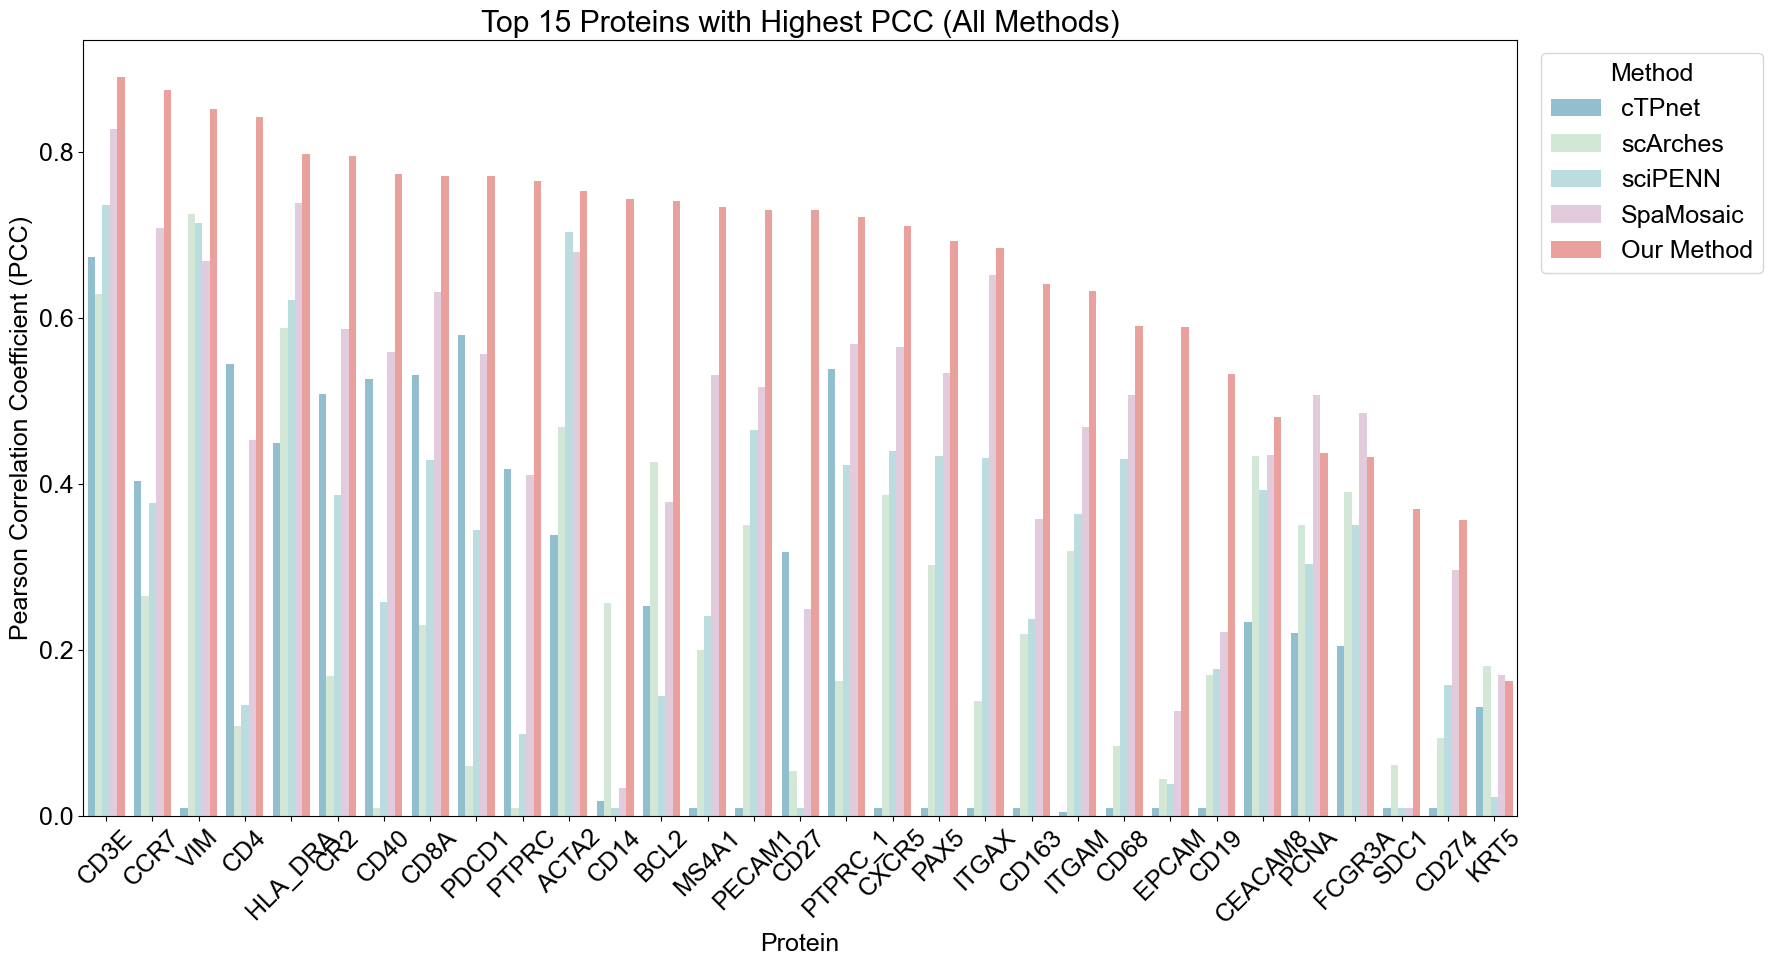

In [33]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm


# 设置 Arial 字体路径  具体路径需要在设置中修改
font_path = './set word/Arial/Arial.ttf'
fm.fontManager.addfont(font_path)

# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18  # 可以根据需要调整字体大小
import seaborn as sns


# 加载数据
omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

# 假设 protein_names 是蛋白名称列表
protein_names = ourbaseline_pre.columns
# 创建一个 DataFrame 用于存储所有方法的 PCC 结果
pcc_protein_df = pd.DataFrame({
    'Protein': protein_names,
    'cTPnet': cTPnet_pcc_protein,
    'scArches': scArches_pcc_protein,
    'sciPENN': sciPENN_pcc_protein,
    'SpaMosaic': spamosaic_pcc_protein,
    'Our Method': our_pcc_protein
})

# # 检查并替换负值为 0.01
# 检查并替换负值为 0.01
pcc_protein_df = pcc_protein_df.apply(lambda x: x.apply(lambda y: 0.01 if y < 0 else y) if x.dtype == 'float64' else x)

# 按 PCC 从大到小排序，提取前 31 个蛋白
pcc_protein_df = pcc_protein_df.sort_values(by='Our Method', ascending=False).head(31)

# 打印结果
print("Top 15 Proteins with Highest PCC (Our Method):")
print(pcc_protein_df)

# 柱状图颜色设置
my_pal = {
    'cTPnet':'#88c4d7',
    'scArches':'#d0ead5',
    'sciPENN':'#b5e2e5',
    'SpaMosaic':'#e6c7df',
    'Our Method':'#f79691'
    }

# 绘制分组柱状图
plt.figure(figsize=(18, 10))
sns.barplot(data=pcc_protein_df.melt(id_vars='Protein', var_name='Method', value_name='PCC'),
            x='Protein', y='PCC', hue='Method', palette=my_pal)

# 添加标签和标题
plt.xlabel('Protein')
plt.ylabel('Pearson Correlation Coefficient (PCC)')
plt.title('Top 15 Proteins with Highest PCC (All Methods)')
plt.xticks(rotation=45)  # 旋转 x 轴标签，避免重叠
plt.legend(title='Method', loc='upper right', bbox_to_anchor=(1.18, 1))

# 调整布局
plt.tight_layout()
plt.show()

In [34]:
cTPnet_pre = cTPnet_pre[proteins_inter]
scArches_pre = scArches_pre[proteins_inter]
sciPENN_pre = sciPENN_pre[proteins_inter]
spamosaic_pre = spamosaic_pre[proteins_inter]
ourbaseline_pre = ourbaseline_pre[proteins_inter]
adata_batch2.obsm['protein_expression']

###  adata_sciPENN_pre 需要单独匹配然后copy spatial
adata_sciPENN_pre = sc.AnnData(sciPENN_pre)

# 假设 data_sciPENN_pre 和 adata_batch2 是 AnnData 对象
proteins_index = adata_batch2.obsm['protein_expression'].index.intersection(sciPENN_pre.index)

# 创建一个全 NaN 的空间坐标矩阵，行数与 adata_sciPENN_pre 的 obs 行数一致
new_spatial = np.full((adata_sciPENN_pre.n_obs, 2), np.nan)

# 获取 adata_batch2 中共同 obs 的空间坐标
common_spatial = omics2[proteins_index].obsm['spatial']

# 将共同 obs 的空间坐标赋值到 new_spatial 中对应的位置
# 使用布尔索引找到 adata_sciPENN_pre 中对应共同 obs 的行
new_spatial[adata_sciPENN_pre.obs.index.isin(proteins_index)] = common_spatial

# 将新矩阵赋值到 adata_sciPENN_pre 的 obsm['spatial']
adata_sciPENN_pre.obsm['spatial'] = new_spatial.copy()

# 验证结果
print(f"Common cells: {proteins_index.size}")
print(f"New spatial shape: {adata_sciPENN_pre.obsm['spatial'].shape}")

Common cells: 1740
New spatial shape: (1740, 2)


In [35]:
# 拼接每个方法的数据(先定义好)
adata_cTPnet_pre = sc.AnnData(cTPnet_pre)
adata_cTPnet_pre.obsm['spatial'] = omics2[split2_indices].obsm['spatial'].copy()

adata_scArches_pre = sc.AnnData(scArches_pre)
adata_scArches_pre.obsm['spatial'] = omics2[split2_indices].obsm['spatial'].copy()

adata_spamosaic_pre = sc.AnnData(spamosaic_pre)
adata_spamosaic_pre.obsm['spatial'] = omics2[split2_indices].obsm['spatial'].copy()

adata_ourbaseline_pre = sc.AnnData(ourbaseline_pre)
adata_ourbaseline_pre.obsm['spatial'] = omics2[split2_indices].obsm['spatial'].copy()

print("✅ 数据拼接完成")


✅ 数据拼接完成


In [36]:
import scanpy as sc
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

# 定义 max-min normalization 函数
def normalize_data(data, vmin, vmax):
    return (data - vmin) / (vmax - vmin)

# 加载数据
omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

# 确保基因名称唯一
omics2.var_names_make_unique()
omics2.var_names = omics2.var_names.str.replace("-", "_")
omics2.var_names = omics2.var_names.str.replace(".", "_")

# 确保 omics2.X 是浮点数且为密集数组
omics2.X = omics2.X.toarray() if scipy.sparse.issparse(omics2.X) else omics2.X
omics2.X = omics2.X.astype(np.float32)

# 提取 omics2 中预测和未预测的部分
omics2_split1 = omics2[split1_indices].copy()
omics2_split2 = omics2[split2_indices].copy()

# # 对 omics2进行归一化
for i in range(omics2.X.shape[1]):
    protein_data = omics2.X[:, i].copy()
    vmin, vmax = np.min(protein_data), np.max(protein_data)
    normalized_protein_data = normalize_data(protein_data, vmin, vmax)
    omics2.X[:, i] = normalized_protein_data

omics2_normalized = omics2.copy()   

# 验证归一化后的数据
print("Normalized data (omics2_normalized.X):", omics2_normalized.X)

# sciPENN 预处理
proteins_index = omics2_normalized.obs_names.get_indexer(sciPENN_pre.index)
unpredicted_indices = np.setdiff1d(np.arange(omics2_normalized.n_obs), proteins_index)

omics2_unpredicted = omics2_normalized[unpredicted_indices].copy()

adata_sciPENN_pre = sc.AnnData(sciPENN_pre)
adata_sciPENN_pre.obsm['spatial'] = omics2_normalized[proteins_index].obsm['spatial'].copy()

for i in range(adata_sciPENN_pre.X.shape[1]):
    protein_data = adata_sciPENN_pre.X[:, i].copy()
    vmin, vmax = np.min(protein_data), np.max(protein_data)
    normalized_protein_data = normalize_data(protein_data, vmin, vmax)
    adata_sciPENN_pre.X[:, i] = normalized_protein_data

def concatenate_data(omics2_unpredicted, adata_method, proteins_index):
    adata_method.var_names_make_unique()
    omics2_unpredicted.var_names_make_unique()
    
    # 确保空间坐标一致
    adata_method.obsm['spatial'] = omics2_normalized[proteins_index].obsm['spatial'].copy()
    
    # 拼接数据
    adata_full = sc.concat([omics2_unpredicted, adata_method], join='outer', merge='same')
    
    return adata_full

adata_sciPENN_full = concatenate_data(omics2_unpredicted, adata_sciPENN_pre, proteins_index)

# 将其他四个方法的预处理逻辑调整为与 sciPENN 方法一致
def preprocess_method(omics2_normalized, method_data, method_index):
    proteins_index_each = omics2_normalized.obs_names.get_indexer(method_index)
    
    # 确保 proteins_index_each 的长度与 method_data 的观测数量一致
    if len(proteins_index_each) != method_data.shape[0]:
        common_indices = np.intersect1d(omics2_normalized.obs_names, method_index)
        proteins_index_each = omics2_normalized.obs_names.get_indexer(common_indices)
        method_data = method_data[method_data.index.isin(common_indices)]
    
    unpredicted_indices = np.setdiff1d(np.arange(omics2_normalized.n_obs), proteins_index_each)

    omics2_unpredicted = omics2_normalized[unpredicted_indices].copy()

    adata_method_pre = sc.AnnData(method_data)
    adata_method_pre.obsm['spatial'] = omics2_normalized[proteins_index_each].obsm['spatial'].copy()

    for i in range(adata_method_pre.X.shape[1]):
        protein_data = adata_method_pre.X[:, i].copy()
        vmin, vmax = np.min(protein_data), np.max(protein_data)
        normalized_protein_data = normalize_data(protein_data, vmin, vmax)
        adata_method_pre.X[:, i] = normalized_protein_data

    adata_method_full = concatenate_data(omics2_unpredicted, adata_method_pre, proteins_index_each)
    
    return adata_method_full

# 对每个方法进行处理
adata_cTPnet_full = preprocess_method(omics2_normalized, cTPnet_pre, cTPnet_pre.index)
adata_scArches_full = preprocess_method(omics2_normalized, scArches_pre, scArches_pre.index)
adata_spamosaic_full = preprocess_method(omics2_normalized, spamosaic_pre, spamosaic_pre.index)
adata_ourbaseline_full = preprocess_method(omics2_normalized, ourbaseline_pre, ourbaseline_pre.index)

# 验证结果
print("adata_cTPnet_full shape:", adata_cTPnet_full.shape)
print("adata_scArches_full shape:", adata_scArches_full.shape)
print("adata_spamosaic_full shape:", adata_spamosaic_full.shape)
print("adata_ourbaseline_full shape:", adata_ourbaseline_full.shape)

# 验证基因名称是否一致
print("adata_cTPnet_full var_names:", adata_cTPnet_full.var_names)
print("omics2_normalized var_names:", omics2_normalized.var_names)

# 验证空间坐标是否一致
print("adata_cTPnet_full obsm['spatial'] shape:", adata_cTPnet_full.obsm['spatial'].shape)
print("omics2_normalized obsm['spatial'] shape:", omics2_normalized.obsm['spatial'].shape)

Normalized data (omics2_normalized.X): [[0.10402887 0.16001645 0.11741666 ... 0.16746315 0.13288139 0.06815   ]
 [0.09003299 0.13330103 0.14721666 ... 0.12017369 0.12904933 0.075     ]
 [0.07839175 0.17454855 0.0586     ... 0.155      0.1093992  0.0549    ]
 ...
 [0.12296083 0.1802431  0.17271666 ... 0.16650526 0.1350305  0.0909    ]
 [0.08836289 0.24835247 0.0682     ... 0.31314737 0.28523117 0.083     ]
 [0.11157938 0.19658327 0.13071667 ... 0.16305263 0.16112007 0.0392    ]]
adata_cTPnet_full shape: (3484, 31)
adata_scArches_full shape: (3484, 31)
adata_spamosaic_full shape: (3484, 31)
adata_ourbaseline_full shape: (3484, 31)
adata_cTPnet_full var_names: Index(['CD163', 'CR2', 'PCNA', 'VIM', 'KRT5', 'CD68', 'CEACAM8', 'PTPRC',
       'HLA_DRA', 'PAX5', 'SDC1', 'PTPRC_1', 'CD8A', 'BCL2', 'CD19', 'PDCD1',
       'ACTA2', 'FCGR3A', 'ITGAX', 'CXCR5', 'EPCAM', 'MS4A1', 'CD3E', 'CD14',
       'CD40', 'PECAM1', 'CD4', 'ITGAM', 'CD27', 'CCR7', 'CD274'],
      dtype='object')
omics2_normaliz

In [37]:
adata_true
adata_true.var_names = adata_true.var_names.str.replace("-", "_")
adata_true.var_names = adata_true.var_names.str.replace(".", "_")
protein_names = protein_names.str.replace("-","_")
protein_names = protein_names.str.replace(".","_")
print("✅ 数据列名替换完成")

✅ 数据列名替换完成


### 这里的图需要修改

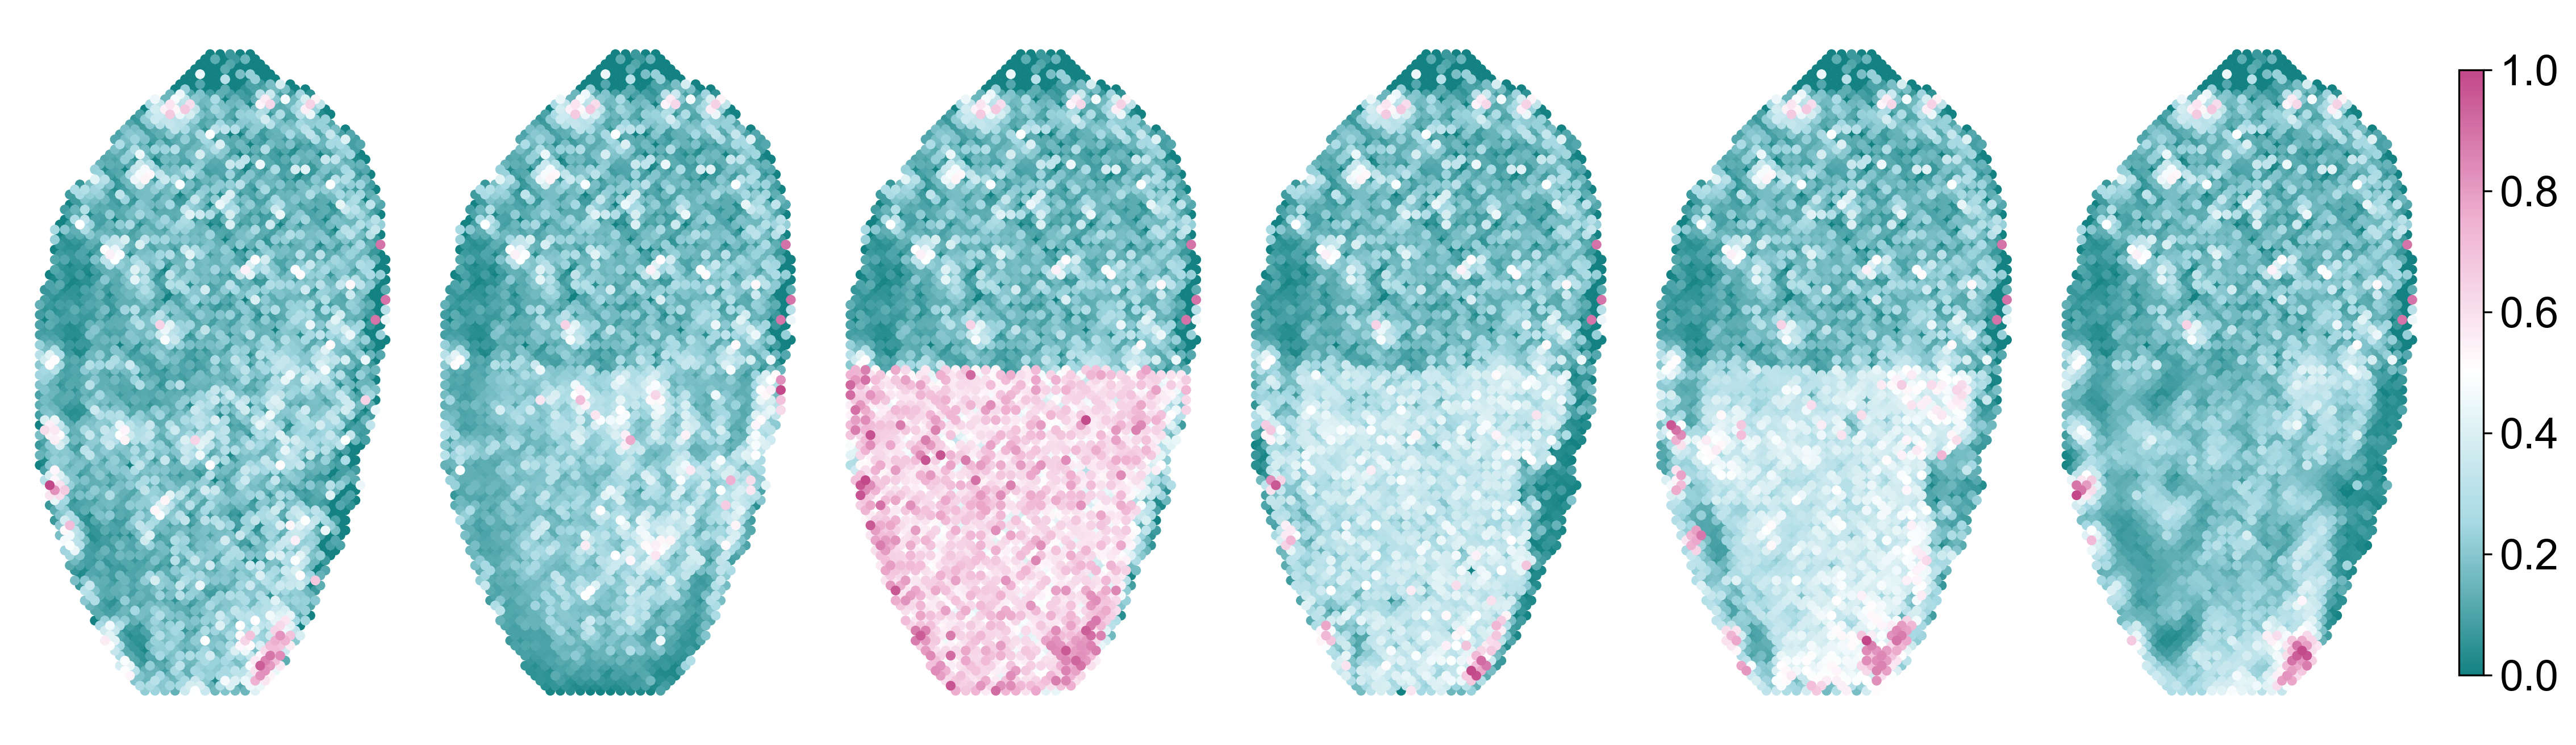

In [ ]:
from matplotlib.cm import ScalarMappable

## 可视化
# 选择要可视化的蛋白（例如第 0 个蛋白）   15:PDCD1   12:CD8A   9:PAX5  10:SDC1
protein_index = 9
protein_name = protein_names[protein_index]

# 获取真实数据坐标范围
spatial_coords_true = omics2.obsm['spatial']
x_min = spatial_coords_true[:, 0].min()
x_max = spatial_coords_true[:, 0].max()
y_min = spatial_coords_true[:, 1].min()
y_max = spatial_coords_true[:, 1].max()

# 动态计算 spot_size
range_x = x_max - x_min
range_y = y_max - y_min
avg_range = (range_x + range_y) / 2
s = avg_range / 50  # 根据实际效果调整分母

# 创建一个 1x6 的 subplot
fig, axs = plt.subplots(1, 6, figsize=(15, 6), dpi=300, constrained_layout=True)
# fig.patch.set_facecolor('#F2FCFC')  # 整体背景色
fig.patch.set_alpha(0)  # 整体背景色

# 创建自定义颜色映射（浅蓝色到浅红色）
# colors = [
#     (0.0, (255/255, 255/255, 250/255, 1.0)),  # 极浅灰 #EEFbFF
#     (0.25, (250/255, 237/255, 212/255, 1.0)), # 淡紫灰 #E7E2EB
#     (0.5, (249/255, 209/255, 173/255, 1.0)),  # 淡粉灰 #EDB4B4
#     (0.75, (231/255, 135/255, 130/255, 1.0)), # 暖橘粉 #E78782
#     (1.0, (223/255, 113/255, 107/255, 1.0))   # 橘红终点 #DF716B
# ]

colors = [
    # (0.0,  (0/255,   130/255, 130/255, 1.0)),  # 蓝绿：#008282
    (0.0,  (20/255, 130/255, 130/255, 1.0)),
    (0.25, (166/255, 217/255, 227/255, 1.0)),  # 浅青：#A6D9E3
    (0.5,  (255/255, 255/255, 255/255, 1.0)),  # 中心白：#FFFFFF
    (0.75, (239/255, 178/255, 210/255, 1.0)),  # 浅粉：#EFB2D2
    (1.0,  (194/255,  72/255, 138/255, 1.0))   # 洋红：#C2488A
]

cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

adata_list = [
    omics2_normalized,
    adata_cTPnet_full,
    adata_scArches_full,
    adata_sciPENN_full,
    adata_spamosaic_full,
    adata_ourbaseline_full
]

titles = [
    f"True {protein_name}",
    f"Predicted {protein_name} (cTPnet)",
    f"Predicted {protein_name} (scArches)",
    f"Predicted {protein_name} (sciPENN)",
    f"Predicted {protein_name} (spamosaic)",
    f"Predicted {protein_name} (ourbaseline)"
]

# 绘制每个 adata 的空间表达图
for i, adata in enumerate(adata_list):
    sc.pl.spatial(
        adata,
        color=protein_name,
        spot_size=s,
        cmap=custom_cmap,  # 自定义颜色
        show=False,
        ax=axs[i],
        vmin=0,  # 归一化后的范围是 [0, 1]
        vmax=1,  # 归一化后的范围是 [0, 1]
        colorbar_loc=None,
    )
    axs[i].set_title(None, fontsize=18)  # 设置无标题
    axs[i].set_axis_off()
    # 翻转 y 轴
    axs[i].invert_yaxis()
# 添加共享颜色条
sm = ScalarMappable(
    cmap=custom_cmap,  # 自定义颜色
    norm=Normalize(vmin=0, vmax=1)  # 归一化后的范围
)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', pad=0.01, shrink=0.6, aspect=25)
cbar.set_label('', fontsize=18)
plt.show()